# GAN Matrics

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 5]


In [34]:
def printGANMetrics(all_values):
    names = ["IS Score", "MMD", "1-NN Acc", "1-NN TPR", "1-NN TNR", "Offline Acc"]
    for i, n in enumerate(names):
        print(names[i].ljust(10), end="\t")
        for v in range(5):
            metric = all_values[v][i]["sg-cgan"]
            avg = np.mean(metric)
            err = stats.sem(metric)
            print("{1:.3f}".format(v, avg), end="  ")
        print("")

In [35]:
def calculateGANMetircs(raw_gan, lst=["all"]):
    
    method = raw_gan["method"].unique()
    
    is_score = {k:[] for k in method}
    is_err = {k:[] for k in method}
    mmd_score = {k:[] for k in method}
    knn_acc = {k:[] for k in method}
    knn_TPR = {k:[] for k in method}
    knn_TNR = {k:[] for k in method}
    offline_acc = {k:[] for k in method}
    training_time = {k:[] for k in method}
    
    for c in lst:
        rows = raw_gan[raw_gan["class"]==c]
        for m in method:
            _m = rows[rows["method"]==m]

            is_score[m].append(float(_m["is"]))
            mmd_score[m].append(float(_m["mmd"]))
            knn_acc[m].append(float(_m["knn_tp"]+_m["knn_tn"])/float(_m["knn_tp"]+_m["knn_tn"]+_m["knn_fp"]+_m["knn_fn"]))
            knn_TPR[m].append(float(_m["knn_tp"])/float(_m["knn_tp"]+_m["knn_fn"]))
            knn_TNR[m].append(float(_m["knn_tn"])/float(_m["knn_tn"]+_m["knn_fp"]))

            offline_acc[m].append(float(_m["offline_acc_fake"]))
        
    return is_score, mmd_score, knn_acc, knn_TPR, knn_TNR, offline_acc, training_time

In [39]:
dataset = "CASAS"
folder = "../../Results/"+dataset+"/exp_gan_layers/"

all_values = []
for cmd in [0, 1, 2, 3, 4]:
    raw_gan = pd.read_csv(folder+str(cmd)+"gan_score.csv")
    raw_gan.columns = [c.strip() for c in raw_gan.columns]
    
    m = calculateGANMetircs(raw_gan, raw_gan["class"].unique())  
    all_values.append(m)
    
printGANMetrics(all_values)

IS Score  	1.463  1.513  1.631  1.431  1.165  
MMD       	0.407  0.590  0.494  0.535  0.857  
1-NN Acc  	0.983  0.985  0.978  0.971  0.998  
1-NN TPR  	0.947  0.943  0.937  0.926  0.992  
1-NN TNR  	1.000  1.000  1.000  1.000  1.000  
Offline Acc	0.802  0.805  1.000  0.801  0.337  


# PCA

In [40]:
from matplotlib import colors as mcolors
colours = list(mcolors.TABLEAU_COLORS.values()) + ["red", "green", "blue", "gold", "black", "yellow"]

In [48]:
def getData(model="sg-cgan", cmd="0"):
    rDir = '../../Dataset/twor.2009/annotated.feat.ch1'
    fDir = '../../Results/CASAS/exp_gan_layers/t0-m'+model+cmd+'-sample.feat'    
    realData = pd.read_csv(rDir)
    fakeData = pd.read_csv(fDir)

    return realData, fakeData

In [72]:
def plotPCA(X, y, labels=["Real", "Generated"], lim=None, filename="plot.pdf"):
    if (X is None) or (y is None):
        return 
    
    fout = plt.figure()
    np.random.seed(0)
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams.update({'font.size': 28})
    plt.rcParams['axes.titlepad'] = 20 
    
    label_colours = ["red", "blue", "orange", "green", "purple"]

    for i, cid in enumerate(labels):
        px = X[(y==cid)]
        if lim is not None:
            plt.xlim(lim[0], lim[1])
            plt.ylim(lim[0], lim[1])
        plt.scatter(px[:, 0], px[:, 1], c=label_colours[i], label=cid)
        
    plt.legend(prop={}, markerscale=3)
    plt.show()
    fout.savefig(filename, bbox_inches='tight')

In [54]:
from sklearn.decomposition import PCA

def runPCA(cls, data, labels):
    np.random.seed(0)
    
    print(cls, [len(d) for d in data])
    trainWith = None
    X = None
    for i in range(len(data)):
        d = data[i]
    
        if cls is not None:
            d = d[d["ActivityName"]==cls]
                
        d["label"] = labels[i]

#         if len(d) > 2000:
#             d = d.sample(n=2000)
        
        if len(d) == 0:
            X = None
            break
            
        if X is None:
            X = d
            trainWith = d
        else:
            X = pd.concat([X, d])
            
    if X is None:
        return None, None, None
    
    X = X.sample(frac=1).reset_index(drop=True)
    
    y = X["label"]
    X = X.drop('ActivityName', 1)
    X = X.drop('label', 1)
    
    trainWith = trainWith.drop('ActivityName', 1)
    trainWith = trainWith.drop('label', 1)

#     tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
    pca = PCA(n_components=2)
    pca.fit(trainWith)
    _X = pca.transform(X)
    
    return _X, y, X


None [17870, 10000]


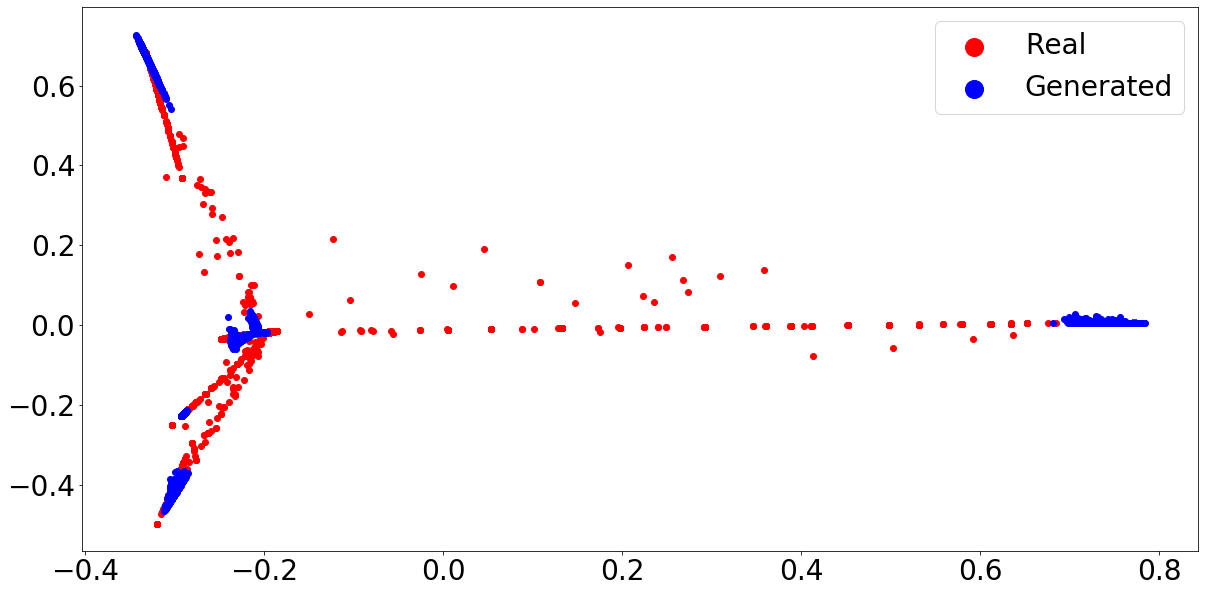

In [73]:
realData, fakeData = getData(cmd="0")
X, y, _ = runPCA(None, [realData, fakeData], ["Real", "Generated"])
plotPCA(X, y, filename="1layer")

None [17870, 10000]


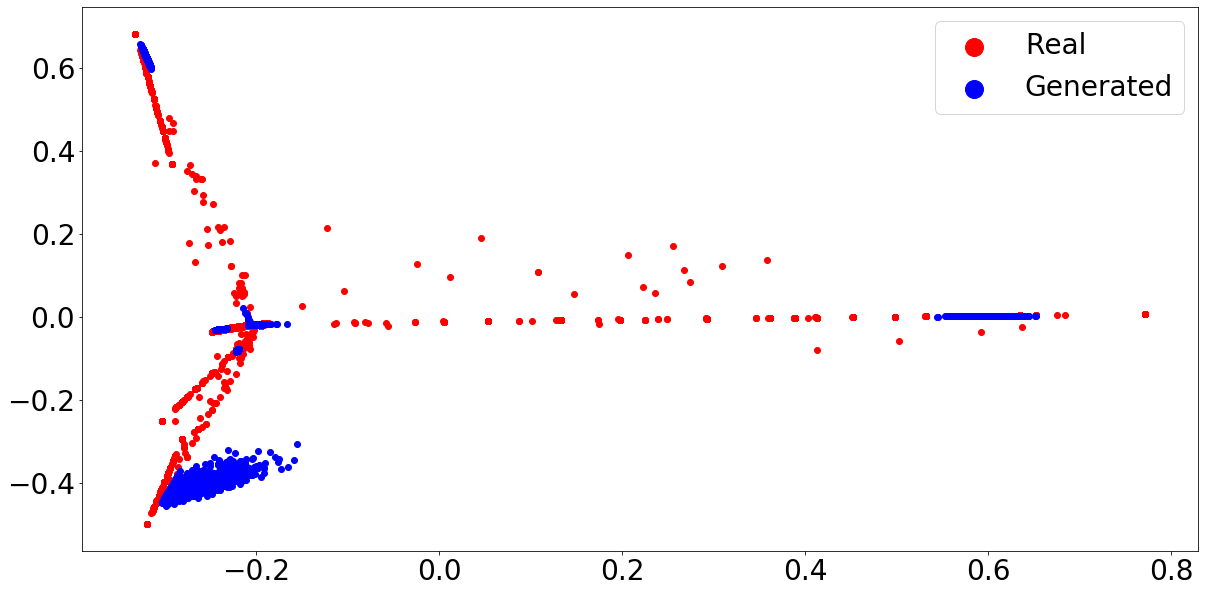

In [74]:
realData, fakeData = getData(cmd="1")
X, y, _ = runPCA(None, [realData, fakeData], ["Real", "Generated"])
plotPCA(X, y, filename="2layer")

None [17870, 10000]


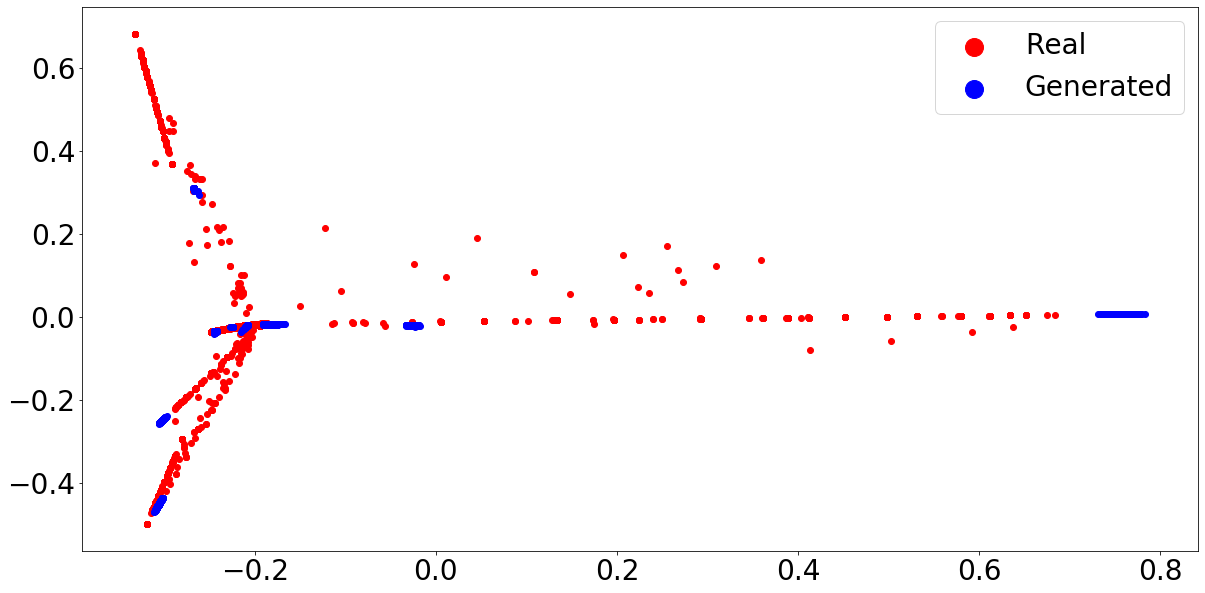

In [75]:
realData, fakeData = getData(cmd="2")
X, y, _ = runPCA(None, [realData, fakeData], ["Real", "Generated"])
plotPCA(X, y, filename="3layer")

None [17870, 10000]


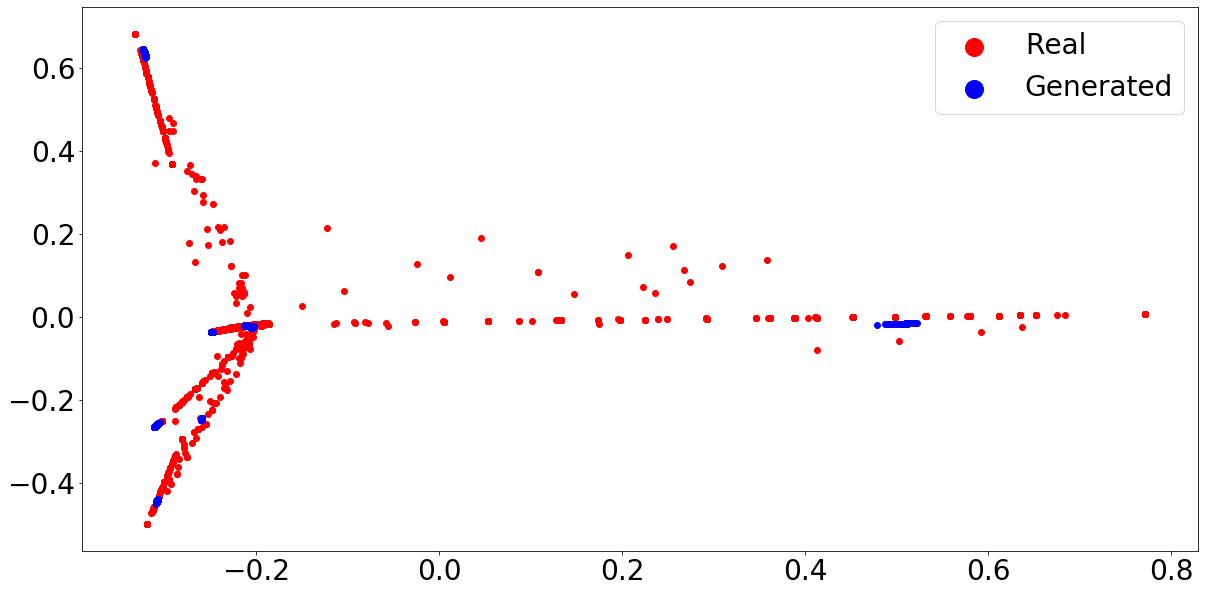

In [76]:
realData, fakeData = getData(cmd="3")
X, y, _ = runPCA(None, [realData, fakeData], ["Real", "Generated"])
plotPCA(X, y, filename="4layer")

None [17870, 10000]


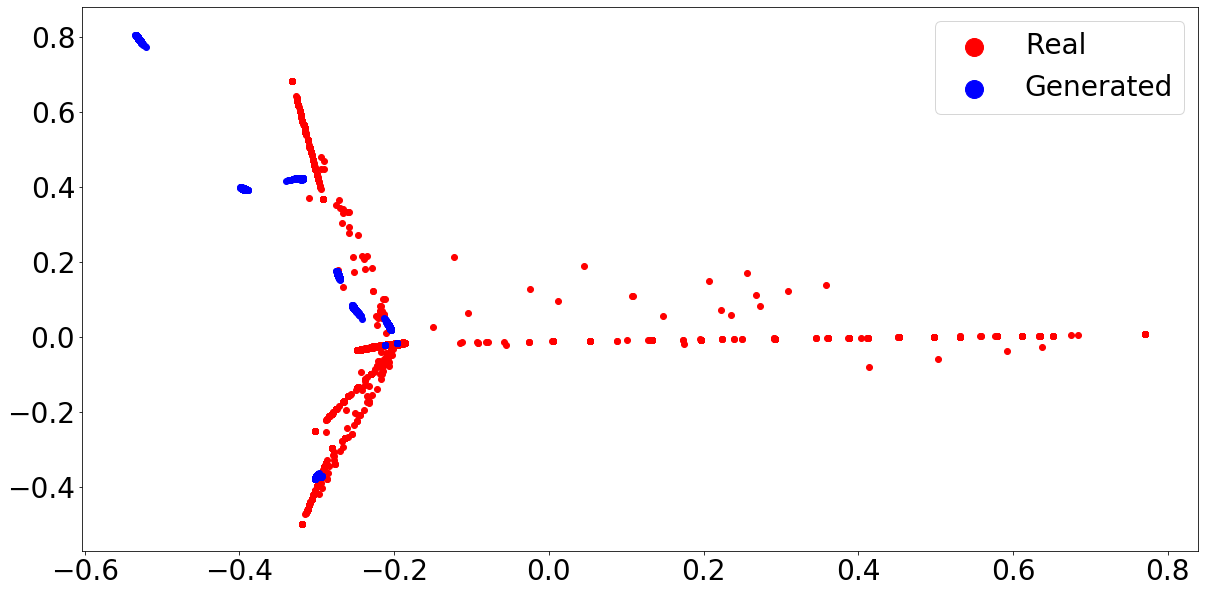

In [77]:
realData, fakeData = getData(cmd="4")
X, y, _ = runPCA(None, [realData, fakeData], ["Real", "Generated"])
plotPCA(X, y, filename="5layer")